# Optimized CNN for notMNIST digit classification with tensorboard visualization



Here we will build a network which is deeper than the  one in  and LeNet5.

The achitecture is:
Input(N,28, 28,1)->{conv(5,5,32, s=1)+ReLu+MaxPool(2,2)}->{conv(5,5,64, s=2)+ReLu+MaxPool(2,2)}->Flatten->FC(1000)->FC(10)->Out

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
#from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  #valid_dataset = save['valid_dataset']
  #valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  #print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

#%%
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
#valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
#print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


Training set (200000, 28, 28) (200000,)
Test set (10000, 28, 28) (10000,)
Training set (200000, 28, 28, 1) (200000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


Next we will use namepace and tensorboard to visualize the network in a better structure. 
we will get something like this

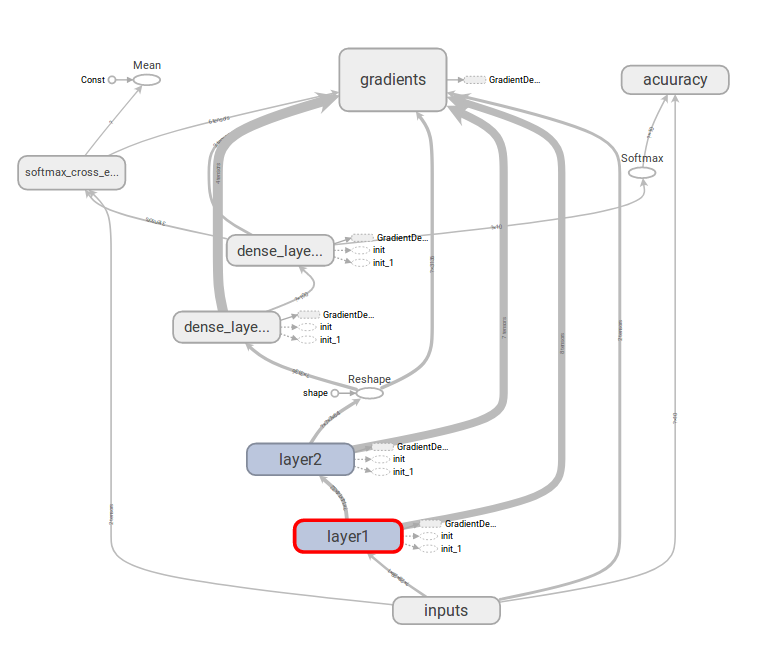

In [20]:
image_size = 28
batch_size = 16
filter_size = 5
in_image_channnels = 1 #grayscale image
depth1 = 32 #no of channels in conv1 layer
depth2 = 64 #no of channels in conv2 layer
num_hidden = 100
learning_rate = 0.05
# define location to store the tensorboard visualization files
STORE_PATH = './../../graph/' 

graph = tf.Graph()

with graph.as_default():
    """
    tensorflow conv2d requires 4D input and filter tensor;
    tf.nn.conv2d(
        input,
        filter,
        strides,
        padding,...)
    input tensor of shape = [batch, in_height, in_width, in_channels]
    filter / kernel tensor of shape = [filter_height, filter_width, in_channels, out_channels]
    """
    
    #define a function that creates convolutional layer
    def create_conv_layer(in_data, num_in_channels, num_out_channels, filter_shape,conv_stride, name, use_subsample= 1):
        ''' in_data = input Data (need 4D shape defined above)
            in_channels = no of channels in input image, 1(grayscale), 3(RGB)
            out_channels = depth of conv layers
            filter_shape = filter shape used for convolution, for e.g. [3,3], or [5,5]
            name = any valid string'''
        #define 4D shape for filter/kernel tensor that will be used for creating weights
        conv_filter_shape = [filter_shape[0], filter_shape[1], num_in_channels, num_out_channels]
        
        weights = tf.Variable(tf.truncated_normal(conv_filter_shape, stddev = 0.1), name = name+ '_W')
        bias = tf.Variable(tf.zeros(num_out_channels), name = name+"_b")
        
        strides = [1, conv_stride[0], conv_stride[1], 1]
        #define the conv2d layer
        outlayer = tf.nn.conv2d(in_data, weights, strides = strides, padding = 'SAME')
        #add bias
        outlayer = outlayer + bias
        #apply ReLu activation
        outlayer = tf.nn.relu(outlayer)
        
        if(use_subsample== 1):
            ## now perform max pooling
            # define the 4D dimension of pooling filter =[1, pool_filter_x, pool_filter_y, 1]
            ksize = [1, 2, 2, 1]
            # now define stride for pool-layer =[1, x-strides, y-strides, 1]
            pool_stride  = [1, 2, 2, 1]
            outlayer = tf.nn.max_pool( outlayer, ksize, strides = pool_stride, padding ='SAME')
        return outlayer
    
    # the dataset train_dataset, train_labels is already formatted
    # Input data placeholders
    # using shape = [None, ] allows us to use it as a general label placeholder
    # shape=(batch_size, image_size, image_size, in_image_channnels)
    with tf.name_scope('inputs'):
        tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, in_image_channnels))
        #tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
        #tf_valid_dataset = tf.constant(valid_dataset)
        #tf_test_dataset = tf.constant(test_dataset)
    
    # MODEL definition
    # now define the two conv layer
    with tf.name_scope('layer1'):
        layer1 = create_conv_layer(tf_train_dataset, in_image_channnels, depth1,\
                               filter_shape =[5,5],conv_stride =[1,1], name ='layer1')
    with tf.name_scope('layer2'):
        layer2 = create_conv_layer(layer1,depth1, depth2, [5,5], [1,1], name ='layer2' )
    
    # now we need to flatten and add two FC layers
    # after two layers with max-pool of stride =2, we go from 28 x 28, to 14 x 14 to 7 x 7 x,y co-ordinates, 
    # but with 16 output channels.  To create the fully connected,
    # "dense" layer, the new shape needs to be [-1, 7 x 7 x 16]
    #flattened = tf.reshape(layer2, [-1, 7 * 7 * 16])
    flattened = tf.reshape(layer2, [-1, 7 * 7 * depth2])
    
    #setup weights and bias for dense layer1
    with tf.name_scope('dense_layer1'):
        w1 = tf.Variable(tf.truncated_normal([7*7* depth2, num_hidden], stddev = 0.1), name ='w_dense1')
        b1 = tf.Variable(tf.zeros([num_hidden]), name ='b_dense1')
        # fully connected layer1
        dense_layer1 = tf.nn.relu(tf.matmul(flattened, w1) + b1)
    
    # weights and bias for dense layer2
    with tf.name_scope('dense_layer2'):
        w2 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev = 0.1), name ='w_dense2')
        b2 = tf.Variable(tf.zeros([num_labels]), name = 'b_dense2')
        # define the output logits = dense_layer2
        logits = tf.matmul(dense_layer1, w2) + b2
        tf.summary.histogram("logits", logits)
    
    # get the logits from the model
    #logits = dense_layer2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))
        
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    prediction = tf.nn.softmax(logits)
    # define an accuracy assessment operation
    with tf.name_scope('acuuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(tf_train_labels, 1))
        accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # add a summary to store the accuracy
    tf.summary.scalar('acc_summary', accuracy_op)
    tf.summary.scalar('loss_summary', loss)
    
    # define image summaries
    with tf.variable_scope('getimages'):
        correct_inputs = tf.boolean_mask(tf_train_dataset, correct_prediction)
        image_summ_true = tf.summary.image('good_images', correct_inputs, max_outputs=5)
        incorrect_inputs = tf.boolean_mask(tf_train_dataset, tf.logical_not(correct_prediction))
        image_summ_false = tf.summary.image('bad_images', incorrect_inputs, max_outputs=5)
    merged = tf.summary.merge_all()
    #end of model


In [21]:
# now training part
epochs = 3
summary_step =0
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    writer = tf.summary.FileWriter(STORE_PATH, session.graph)
    total_batches = int(train_labels.shape[0]/batch_size)
    #total_batches = 1001 # = num_Steps
    print(" Total training dataset length: ", len(train_labels))
    print(" total no of batches: ", total_batches)
    for epoch in range(epochs):
      for i in range(total_batches):
          offset = (i * batch_size)
          batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
          batch_labels = train_labels[offset:(offset + batch_size), :]
          feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
          _, l, summary = session.run([optimizer, loss,merged], feed_dict=feed_dict)
          global_step +=1
          if (global_step% 2000 == 0):
                writer.add_summary(summary, global_step//1999)
                print("At Step = %d, Minibatch train_accuracy = %f " \
                      %(global_step,session.run(accuracy_op, feed_dict = feed_dict)))
          del batch_data, batch_labels, feed_dict
      test_len = int(len(test_labels)/2) # only taking half length
      test_acc1 = session.run(accuracy_op, \
                             feed_dict ={tf_train_dataset:test_dataset[0:test_len, :, :, :],tf_train_labels: test_labels[0:test_len, :]})
      test_acc2 = session.run(accuracy_op, \
                             feed_dict ={tf_train_dataset:test_dataset[test_len:, :, :, :],tf_train_labels: test_labels[test_len:, :]})
      # find the avg test acuuracy from the accuracy of 1st half and 2nd half
      test_acc = (test_acc1 + test_acc2) /2.0
      print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(l), " test accuracy: {:.2f}%".format(test_acc*100))
print("\nTraining complete!")



Initialized
 Total training dataset length:  200000
 total no of batches:  12500
At Step = 42000, Minibatch train_accuracy = 0.937500 
At Step = 44000, Minibatch train_accuracy = 0.937500 
At Step = 46000, Minibatch train_accuracy = 1.000000 
At Step = 48000, Minibatch train_accuracy = 1.000000 
At Step = 50000, Minibatch train_accuracy = 1.000000 
At Step = 52000, Minibatch train_accuracy = 0.937500 
Epoch: 1 cost = 0.560  test accuracy: 95.13%
At Step = 54000, Minibatch train_accuracy = 1.000000 
At Step = 56000, Minibatch train_accuracy = 0.937500 
At Step = 58000, Minibatch train_accuracy = 1.000000 
At Step = 60000, Minibatch train_accuracy = 1.000000 
At Step = 62000, Minibatch train_accuracy = 1.000000 
At Step = 64000, Minibatch train_accuracy = 0.875000 
Epoch: 2 cost = 0.635  test accuracy: 95.96%
At Step = 66000, Minibatch train_accuracy = 0.937500 
At Step = 68000, Minibatch train_accuracy = 1.000000 
At Step = 70000, Minibatch train_accuracy = 0.875000 
At Step = 72000, Mi

Run the following in command prompt; we need to point to the STORE_PATH directory 

$ tensorboard --logdir=path_to_store_dir

Ctrl+click on the link and you would see the following:

Default tab is "scalar". Here you would see the "loss" and "accurary" over sampled training iterations.
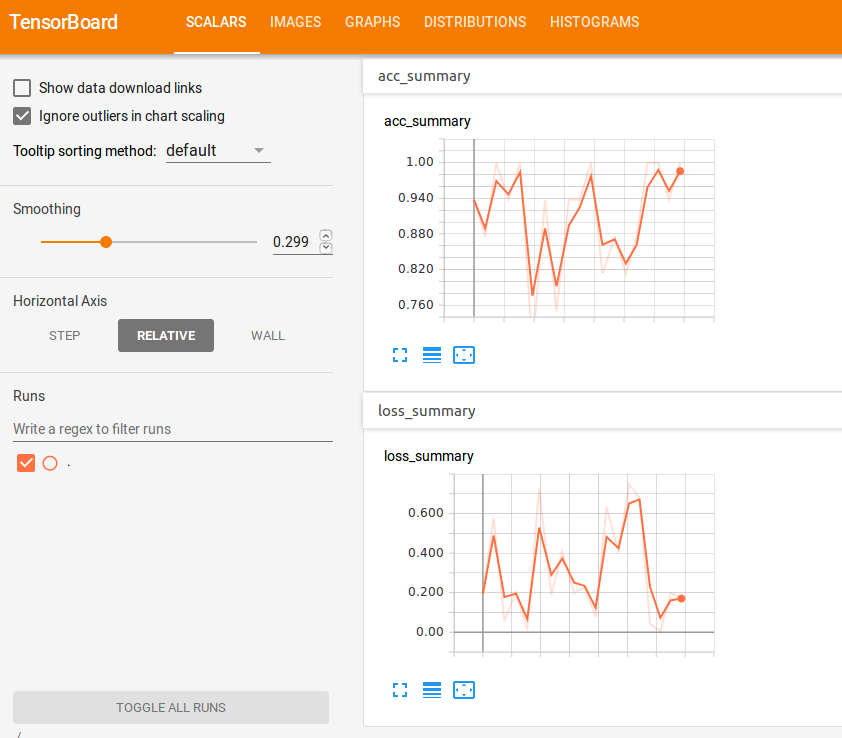

Click on the **Graph** tab to see the graphical representation of the model;

Click  on the **images** tab to check sample of good and bad cases.

Feel free to zoom in and check the variables dimension and individual blocks.

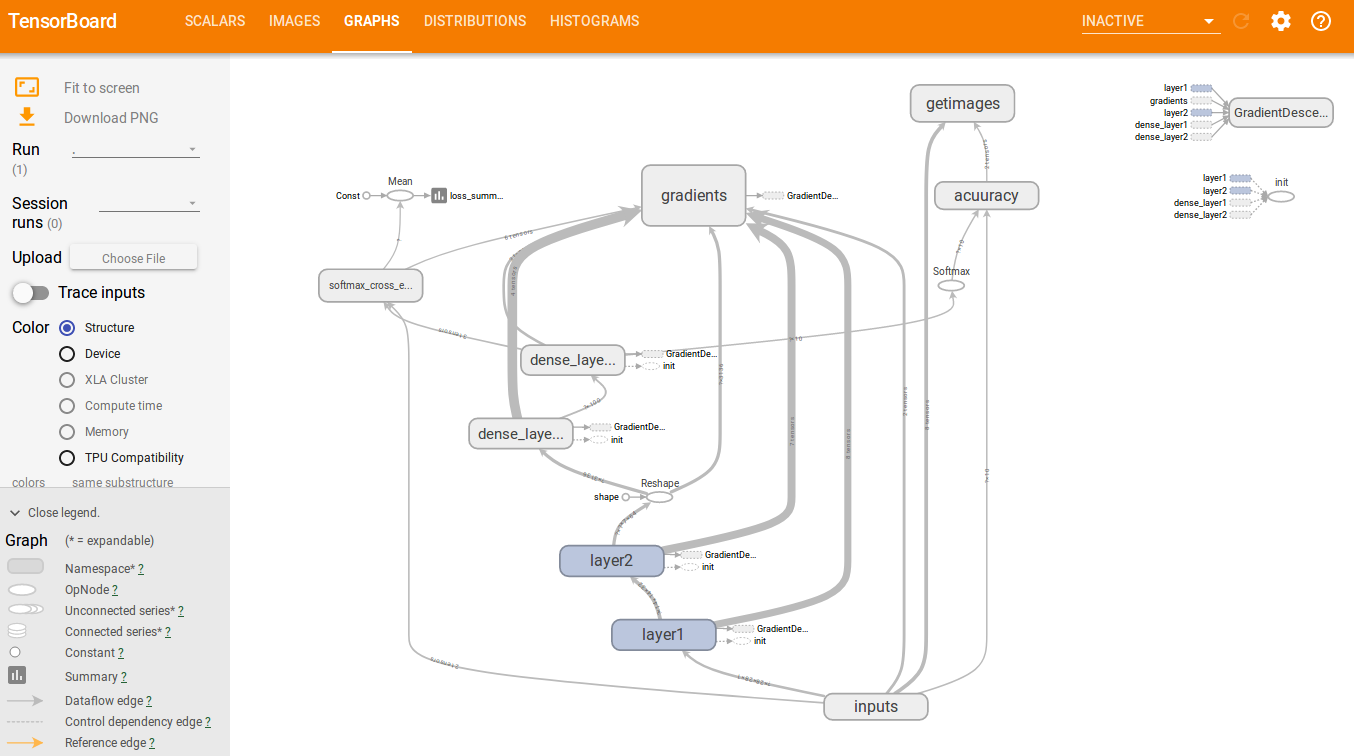